# ICOAADS SST (likely duplicated in SST products)

- datasets_IMMA_ICOADS_ncei_2000s which was ingested from ncei version of ICOADS data **TODO**
- datasets_IMMA_ICOADS_ncei_2010s which was ingested from ncei version of ICOADS data

In [20]:
import datetime
from erddapy import ERDDAP
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cmocean

#using xarray for bathymetry data read
import xarray as xa
from requests.exceptions import HTTPError


In [21]:
server_url = 'http://akutan.pmel.noaa.gov:8080/erddap'

In [3]:
e = ERDDAP(server=server_url)
# searchterm mooring... subset this later
df = pd.read_csv(e.get_search_url(response='csv', search_for='datasets_IMMA_ICOADS_ncei_2010s'))
dataset_id=df['Dataset ID'][0]

In [4]:
constraints = {
    'latitude>=': 45,
    'longitude>=': 170,
    'longitude<=': 2100,
    'SST>=': -2,
    'SST<=': 30,
    'QI10<=': 2
}

variables = ['latitude, longitude, SST, time']

extent=[-179.5, -150, 52.5, 72]

In [5]:
try:
    d = ERDDAP(server=server_url,
        protocol='tabledap',
        response='csv',
    )
    d.constraints=constraints
    d.dataset_id=dataset_id

    df_m = d.to_pandas(
                #index_col='time (UTC)',
                parse_dates=True,
                skiprows=(1,)  # units information can be dropped.
                )
    df_m.sort_index(inplace=True)
    df_m.columns = [x[1].split()[0] for x in enumerate(df_m.columns)]

except:
    print(f"something failed in data download {dataset_id}")
    pass

something failed in data download datasets_IMMA_ICOADS_ncei_2010s


In [7]:
# alternatively - the data has been downlaoded and put into /data
df_m=pd.read_csv('data/datasets_IMMA_ICOADS_ncei_2010s_38ab_860e_867d.csv',skiprows=[1],parse_dates=True)

In [8]:
df_m

,time,latitude,longitude,SST,QI10
0,2010-01-11T06:00:00Z,56.6,207.9,6.0,1
1,2010-01-14T06:00:00Z,57.6,179.4,2.0,1
2,2010-03-12T12:00:00Z,56.8,208.7,6.0,1
3,2010-06-20T00:00:00Z,62.3,180.4,3.3,1
4,2010-06-20T06:00:00Z,62.9,182.3,3.5,1
...,...,...,...,...,...
2167,2014-09-07T06:00:00Z,63.8,186.0,8.8,1
2168,2014-09-08T00:00:00Z,62.3,180.7,11.1,1
2169,2014-09-27T00:00:00Z,64.3,182.7,9.0,1
2170,2014-09-29T12:00:00Z,64.7,184.6,3.0,1


In [9]:
#topo if wanted
server_url = 'https://coastwatch.pfeg.noaa.gov/erddap/griddap/usgsCeSS111'
bathy = xa.open_dataset(server_url) 
bathy_sub = bathy.sel(latitude=slice(extent[3],extent[2]),longitude=slice(extent[0],extent[1]))


def make_map(projection=ccrs.PlateCarree()):
    """subroutine to specify basemap"""
    fig, ax = plt.subplots(figsize=(12,12),
                           subplot_kw=dict(projection=projection))
    if projection == ccrs.PlateCarree():
        gl = ax.gridlines(draw_labels=True)
        gl.xlabels_top = gl.ylabels_right = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

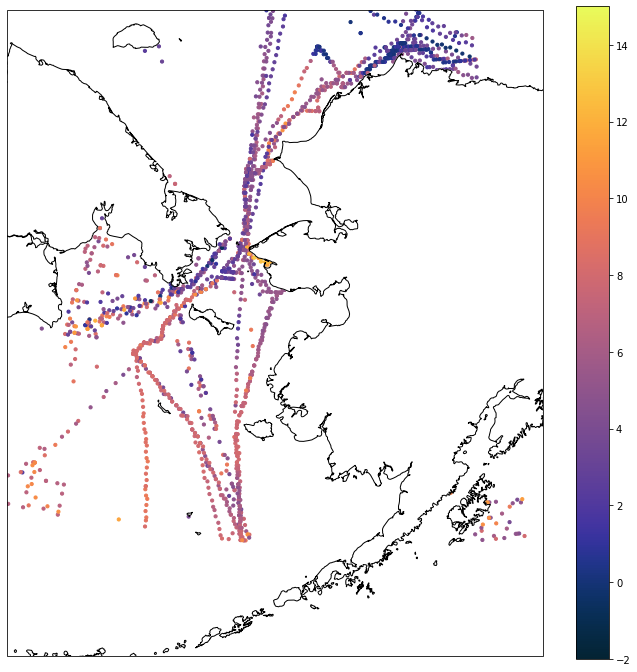

In [10]:
#make maps
projection=ccrs.LambertConformal(central_longitude=-160.0)
transformation=ccrs.PlateCarree()

land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                                edgecolor='face',
                                                facecolor='1.0')

fig,ax = make_map(projection=projection)

c = ax.scatter(df_m.longitude, df_m.latitude, s=10,
               c=df_m.SST, cmap=cmocean.cm.thermal,
               vmin=-2, vmax=15,
               transform=transformation)
plt.colorbar(c)
ax.add_feature(land_50m)
ax.coastlines(resolution='10m')
ax.set_extent(extent)

fig.savefig('2010ICOADS'+'.png',dpi=300)

## Find Nearest Neighbor

without any temporal averaging... just let the algorithm choose.  We may have to figure out how to compare one year at a time

## load previously downloaded model data

In [17]:
#open_dataset vs load_dataset

#HROISST
xa_HROISST = xa.open_mfdataset('/Users/bell/in_and_outbox/data_sets/sst/NBS_SST_Models/HROISSTV2/NBS_CK_HROISST_*.nc')

xa_HROISST_subset = xa_HROISST['sst'].sel(time=slice('2010-01-01','2019-12-31'),
                                     longitude=slice(170,210))

#UKMET

xa_UKMET = xa.open_mfdataset('/Users/bell/in_and_outbox/data_sets/sst/NBS_SST_Models/UKMET/NBS_CK_UKMET_*.nc')

xa_UKMET_subset = xa_UKMET['analysed_sst'].sel(time=slice('2010-01-01','2019-12-31'),
                                     longitude=slice(-180,-150))

In [22]:
df_m['hroisst'] = np.nan
df_m['ukmetsst'] = np.nan

for row, value in df_m.iterrows():

    df_m['hroisst'][row] = xa_HROISST_subset.sel(time=str(value['time']),
                                                latitude=value['latitude'],
                                                longitude=value['longitude'],
                                                method='nearest')
    df_m['ukmetsst'][row] = xa_UKMET_subset.sel(time=str(value['time']),
                                                latitude=value['latitude'],
                                                longitude=value['longitude']-360,
                                                method='nearest')

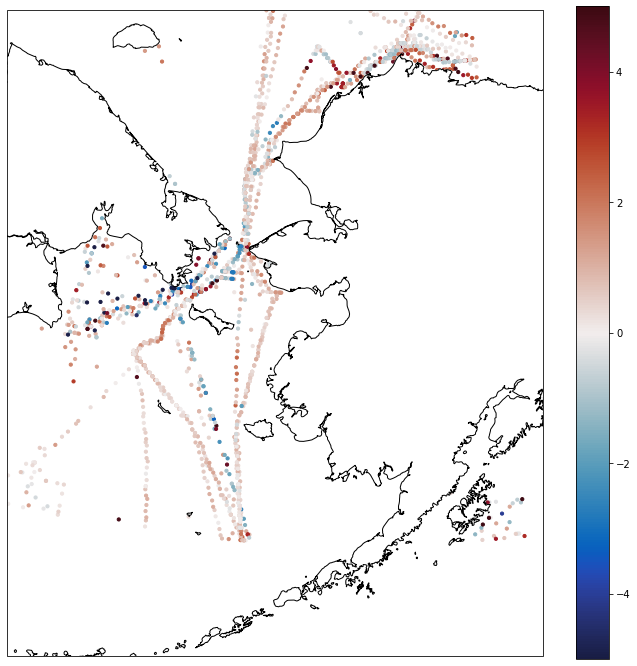

In [23]:
#make maps
projection=ccrs.LambertConformal(central_longitude=-160.0)
transformation=ccrs.PlateCarree()

land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                                edgecolor='face',
                                                facecolor='1.0')

fig,ax = make_map(projection=projection)

c = ax.scatter(df_m.longitude, df_m.latitude, s=10,
               c=(df_m.SST-df_m.hroisst), cmap=cmocean.cm.balance,
               vmin=-5, vmax=5,
               transform=transformation)
plt.colorbar(c)
ax.add_feature(land_50m)
ax.coastlines(resolution='10m')
ax.set_extent(extent)

fig.savefig('ICOADS_HROISST.png',dpi=300)

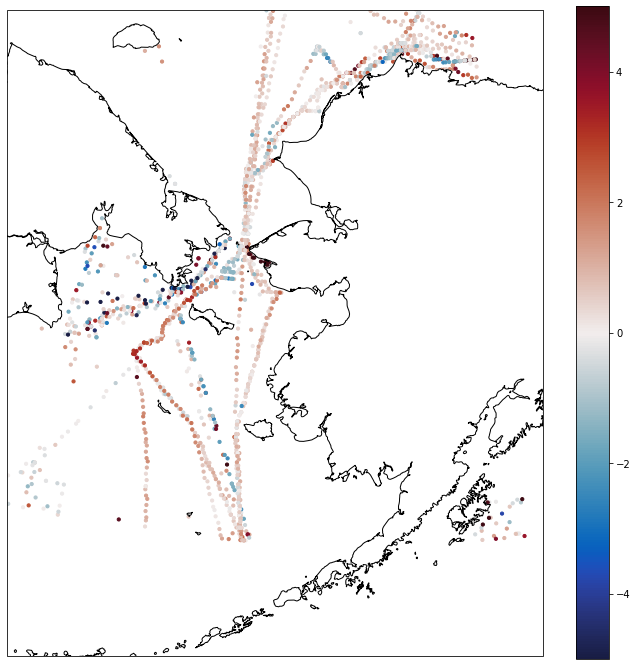

In [24]:
#make maps
projection=ccrs.LambertConformal(central_longitude=-160.0)
transformation=ccrs.PlateCarree()

land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                                edgecolor='face',
                                                facecolor='1.0')

fig,ax = make_map(projection=projection)

c = ax.scatter(df_m.longitude, df_m.latitude, s=10,
               c=(df_m.SST-df_m.ukmetsst), cmap=cmocean.cm.balance,
               vmin=-5, vmax=5,
               transform=transformation)
plt.colorbar(c)
ax.add_feature(land_50m)
ax.coastlines(resolution='10m')
ax.set_extent(extent)

fig.savefig('ICOADS_UKMET.png',dpi=300)

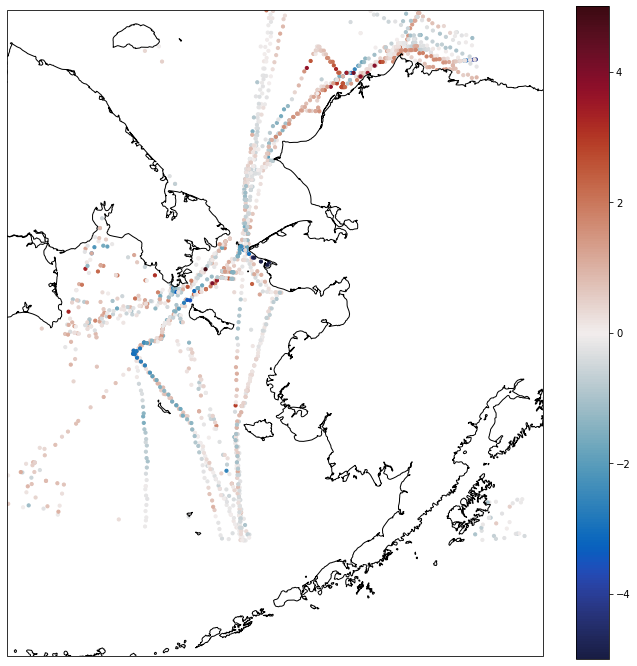

In [49]:
#make maps
projection=ccrs.LambertConformal(central_longitude=-160.0)
transformation=ccrs.PlateCarree()

land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                                edgecolor='face',
                                                facecolor='1.0')

fig,ax = make_map(projection=projection)


c = ax.scatter(df_m.longitude, df_m.latitude, s=10,
               c=(df_m.ukmetsst-df_m.hroisst), cmap=cmocean.cm.balance,
               vmin=-5, vmax=5,
               transform=transformation)
plt.colorbar(c)
ax.add_feature(land_50m)
ax.coastlines(resolution='10m')
ax.set_extent(extent)

fig.savefig('ICOADS_UKMET-HROISST.png',dpi=300)

In [62]:
#df_m.set_index(df_m.time,inplace=True)
df_m.plot(x='time',y=(df_m.SST-df_m.hroisst))


KeyError: "None of [Float64Index([    0.679999828338623,   -0.1700000762939453,\n                  1.309999942779541,     0.909999895095825,\n                 0.9100000858306885,    0.7699999809265137,\n                -0.5000000953674317, -0.059999942779541016,\n                 0.7000000000000002,    0.6000001907348631,\n              ...\n                 -9.609999656677246,    0.3700000762939446,\n                 0.2000003814697262,    -1.760000228881836,\n                -2.3499999046325684,   -1.0800001144409173,\n                 0.9199996948242184,    0.8900003433227539,\n                               -3.5,   -1.5999999046325684],\n             dtype='float64', length=2172)] are in the [columns]"

<AxesSubplot:xlabel='time'>

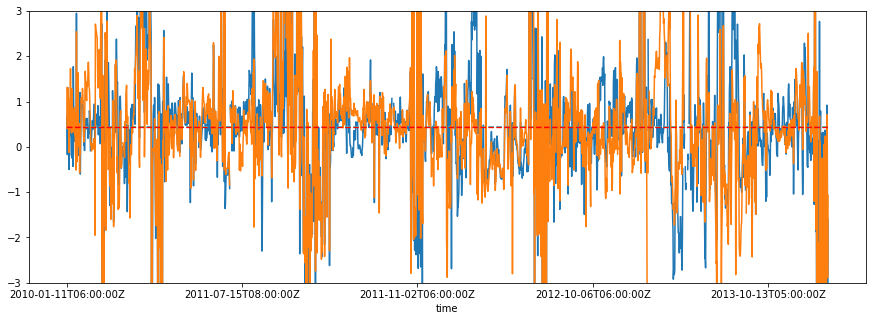

In [75]:
(df_m.SST-df_m.hroisst).plot(figsize=(15, 5),ylim=(-3,3))
(df_m.SST*0+(df_m.SST-df_m.hroisst).mean()).plot(c='cyan',linestyle='--')
(df_m.SST-df_m.ukmetsst).plot()
(df_m.SST*0+(df_m.SST-df_m.ukmetsst).mean()).plot(c='red',linestyle='--')

In [69]:
df_m

,time,latitude,longitude,SST,QI10,hroisst,ukmetsst
time,,,,,,,
2010-01-11T06:00:00Z,2010-01-11T06:00:00Z,56.6,207.9,6.0,1,5.32,4.689994
2010-01-14T06:00:00Z,2010-01-14T06:00:00Z,57.6,179.4,2.0,1,2.17,1.599994
2010-03-12T12:00:00Z,2010-03-12T12:00:00Z,56.8,208.7,6.0,1,4.69,4.699994
2010-06-20T00:00:00Z,2010-06-20T00:00:00Z,62.3,180.4,3.3,1,2.39,2.609994
2010-06-20T06:00:00Z,2010-06-20T06:00:00Z,62.9,182.3,3.5,1,2.59,2.419994
...,...,...,...,...,...,...,...
2014-09-07T06:00:00Z,2014-09-07T06:00:00Z,63.8,186.0,8.8,1,9.88,10.939994
2014-09-08T00:00:00Z,2014-09-08T00:00:00Z,62.3,180.7,11.1,1,10.18,10.389994
2014-09-27T00:00:00Z,2014-09-27T00:00:00Z,64.3,182.7,9.0,1,8.11,8.439994
